# Imports

In [134]:
# Imports
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams["axes.grid"] = False #disable ugly white lines which are present in google colab for matplotlib
import numpy as np
import datetime
today = datetime.datetime.today() #To work with datetime values. Only relative time matters in this project, so selecting a random date is not a problem. 
from sklearn.metrics import classification_report,auc,r2_score,matthews_corrcoef
import shap
from catboost import CatBoostClassifier,CatBoostRegressor,Pool
from catboost.utils import get_roc_curve
import pandas as pd
import re
import os
from scipy.stats import linregress,ttest_ind,ranksums
uzgent_data_path = "../data/uzgent/"
amsterdam_data_path = "../data/amsterdam/"
from tabulate import tabulate

In [135]:
pd.set_option('display.max_columns', None)

In [136]:
present = False
if present:
    params = {"ytick.color" : "w",
            "xtick.color" : "w",
            "axes.titlecolor" : "w",
            "axes.labelcolor" : "w",
            "axes.edgecolor" : "w"}
    plt.rcParams.update(params)
    plt.rcParams.update({'font.size': 18})
else:
    params = {"ytick.color" : "black",
            "xtick.color" : "black",
            "axes.titlecolor" : "black",
            "axes.labelcolor" : "black",
            "axes.edgecolor" : "black"}
    plt.rcParams.update(params)

# External Validation

In [137]:
def ece_calculator(X,y,model,plot_bool=False):
    confidences = np.max(model.predict_proba(X),axis=1)
    output_t = np.argmax(model.predict_proba(X),axis=1)

    max_bin = 5

    ECE_arr = np.array([])
    cal_plot_ECE = list([])
    ESCE_arr = np.array([])
    for i in np.arange(0.5,max_bin + 0.1,0.1):
        bins_size = i#1.5
        bin_epsilon = 0.00001
        bin_min = np.round(np.min(confidences*100))

        pred_out = output_t
        real_out = y.values
        bins_correct = plt.hist(confidences[np.where(pred_out==real_out)]*100,density=False,label="Correct pred",bins=np.arange(bin_min,101.0,bins_size),ec='black')#,color="#e898ac",ec='white')
        bins_incorrect = plt.hist(confidences[np.where(pred_out!=real_out)]*100,density=False,label="Incorrect pred",bins=np.arange(bin_min,101.0,bins_size),ec='black')#,color="#e898ac",ec='white')
        

        bin_means = np.array([])
        for b in np.arange(bin_min,101.0,bins_size):
            bin_means = np.append(bin_means,np.array(np.mean(np.append([bin_epsilon],confidences[np.where((confidences > b/100.0)&(confidences <= (b/100.0+bins_size/100.0)))]))))

        bin_means = bin_means[:-1]

        #avg accuracy per bin - avg confidence per bin (summed over all bins and normalized by width of size of bin)
        ECE = np.sum((bins_correct[0]+bins_incorrect[0])/len(confidences) * (np.abs(bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon) - bin_means)))
        cal_plot_ECE.append(np.array((bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon))))
        ESCE = np.sum((bins_correct[0]+bins_incorrect[0])/len(confidences) * (bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon) - bin_means))
        ECE_arr = np.append(ECE_arr,np.array(ECE))
        ESCE_arr = np.append(ESCE_arr,np.array(ESCE))

    plt.clf()

    if plot_bool:
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0.5,max_bin + 0.1,0.1),ECE_arr*100,label="avg ECE")
        plt.plot(np.arange(0.5,max_bin + 0.1,0.1),ESCE_arr*100,label="avg ESCE")

        plt.legend()
        plt.xlabel("Bin size ")
        # plt.xlim([0.5,10])
        plt.ylabel("ECE (% error)")
        plt.show()

        plt.figure(figsize=(12,8))

        bin_min = np.round(np.min(confidences*100))

        mean_sece = np.array([])
        increment_perc = 1
        for perc in np.arange(bin_min+increment_perc,100+increment_perc,increment_perc):
            mean_array = np.array([])
            idx = 0
            for calplots in cal_plot_ECE:
                bins_size = np.arange(0.5,max_bin + 0.1,0.1)[idx]
                plot_arr = np.where(calplots!=0)

                x_ar = (np.arange(bin_min,101.0,bins_size)[:-1]+bins_size/2)[plot_arr]
                cal_plot_mean = calplots[plot_arr][np.where((x_ar < perc) & (x_ar >= perc-increment_perc))]
                
                if len(cal_plot_mean>0):
                    temp_mean = np.mean(cal_plot_mean)
                    mean_array = np.append(mean_array,temp_mean)
                
                idx += 1

            mean_sece = np.append(mean_sece,np.mean(mean_array))


        for i in range(len(cal_plot_ECE)):
            bins_size = np.arange(0.5,max_bin + 0.1,0.1)[i]
            x_ar = np.arange(bin_min,101.0,bins_size)[:-1]+bins_size/2
            plot_arr = np.where(cal_plot_ECE[i]!=0)
            plt.plot(x_ar[plot_arr],cal_plot_ECE[i][plot_arr]*100,alpha=0.2,color="blue")
        plt.plot(np.arange(bin_min+increment_perc/2,100+increment_perc/2,increment_perc),mean_sece*100,color="red",label="average")
        plt.plot([50,100],[50,100],color="black",label="Perfect calibration")
        plt.xlim([50,100])
        plt.ylim([0,100])
        plt.xticks(np.arange(50,104,5))
        plt.xlabel("Predicted probabilities (%)")
        plt.ylabel("Observed probabilities (%)")
        plt.grid()
        plt.legend()
        plt.show()

    print("ECE normalized AUC (%) = "+str(np.round(np.mean(ECE_arr)*100,2))+" %")
    print("ESCE normalized AUC (%) = "+str(np.round(np.mean(ESCE_arr)*100,2))+" %")

    return np.mean(ECE_arr),np.mean(ESCE_arr)

def pandas_result_AF_maker(patient_group_string,X,y,model,append_df):
    (fpr, tpr, thresholds) = get_roc_curve(model, Pool(data=X,label=y), plot=False)
    res_dict = classification_report(y,model.predict(X),target_names=["No-AF","AF"],output_dict=True)

    ECE,ESCE = ece_calculator(X,y,model)

    append_df = pd.concat([append_df,pd.DataFrame(data=[[model_string,validation_type_string,patient_group_string,
                    res_dict["No-AF"]["support"],res_dict["AF"]["support"],
                    res_dict["No-AF"]["recall"],res_dict["AF"]["recall"],
                    res_dict["No-AF"]["precision"],res_dict["AF"]["precision"],
                    res_dict["No-AF"]["f1-score"],res_dict["AF"]["f1-score"],
                    matthews_corrcoef(y,model.predict(X)),auc(fpr,tpr),ECE,ESCE
                   ]],columns=uzgent_result_dataframe_columns)])
    
    return append_df


uzgent_result_dataframe_columns=["model","validation_type","patient_group","NO AF patients","AF patients","NO AF recall","AF recall","NO AF precision","AF precision","NO AF f1","AF f1","mcc","auc","ECE","ESCE"]
# uzgent_result_dataframe = pd.DataFrame(columns=uzgent_result_dataframe_columns)

uzgent_p_value_result_dataframe_columns=["model","comparison","AF_group","p_value"]
# uzgent_p_value_result_dataframe = pd.DataFrame(columns=uzgent_p_value_result_dataframe_columns)

# missing_dataframe = pd.DataFrame(columns=["model","feature","train amst","balanced test amst","all test amst","train uzgent","balanced test uzgent","all test uzgent"])

In [138]:
#uzgent_result_dataframe.reset_index(drop=True).to_csv("../results/uzgent_af_prediction_results.csv")

In [139]:
#True
#False

one_half_hour_model = False
six_hour_model = True

model_string = ("1.5"*int(one_half_hour_model)+"12"*int(1-one_half_hour_model))*int(1-six_hour_model)+"6"*int(six_hour_model)
print(model_string)

6


## Transfer validation

In [140]:
validation_type_string = "transfer"

### Data import

In [141]:
if one_half_hour_model:
    AF_dataset = pd.read_csv(uzgent_data_path+"AF_dataset_1_5_hours.csv") 
elif six_hour_model:
    AF_dataset = pd.read_csv(uzgent_data_path+"AF_dataset_6_hours.csv") 
else:
    AF_dataset = pd.read_csv(uzgent_data_path+"AF_dataset_12_hours.csv") 

        
AF_dataset = AF_dataset.rename(columns={"HospAdmissionID":"patientid","AgeOnAdmission":"Age","ICUSessionID":"admissionid"})
AF_dataset.loc[AF_dataset.sepsis_extra_opn_measuredat > AF_dataset.AF_measuredat,"sepsis_bool_extra_opn"]=0

AF_dataset.loc[(~AF_dataset.bmi.isna())&(AF_dataset.bmi.str.contains(",")),'bmi']=np.NaN

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


In [142]:
AF_dataset["is_given_NORepinefrine"]=0
AF_dataset.loc[AF_dataset['mean_CV_norepinephrine']>0,"is_given_NORepinefrine"]=1


AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[(AF_dataset["mean_VI_calcium carbonate"]>1)|(AF_dataset["mean_VI_calcium chloride"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset["is_given_Dopamine (Inotropin)"]=0
AF_dataset.loc[AF_dataset['mean_CV_dopamine']>0,"is_given_Dopamine (Inotropin)"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_NS_propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Fentanyl']=0
AF_dataset.loc[AF_dataset['mean_NS_fentanyl']>0,'is_given_Fentanyl']=1

AF_dataset["is_given_Furosemide (Lasix)"]=0
AF_dataset.loc[AF_dataset['mean_DI_furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(AF_dataset['mean_DI_furosemide']>0),"is_given_LoopDiuretics"]=1

AF_dataset["sepsis_bool"]=0
AF_dataset.loc[(AF_dataset.sepsis_bool_comorb_source==1) | (AF_dataset.sepsis_bool_extra_opn==1),"sepsis_bool"]=1

AF_dataset.loc[AF_dataset['mean_PEEP_M_ALL'].isna(),"mean_PEEP_M_ALL"]=0

AF_dataset.loc[AF_dataset.icuurg=="Urgent","icuurg"]=1
AF_dataset.loc[AF_dataset.icuurg!=1,"icuurg"]=0


In [143]:
#Rename for distr change 12 hour model
AF_dataset = AF_dataset.rename(columns={'mean_PEEP_M_ALL':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_URINE_VOL':'mean_UrineCAD', 
                            'max_PEEP_M_ALL':'max_PEEP (Set)','min_PEEP_M_ALL':'min_PEEP (Set)',
                            'max_PHOSPHATE_ALL':'max_Fosfaat (bloed)','min_HR_ALL':'min_Hartfrequentie','mean_HR_ALL':'mean_Hartfrequentie','slope_HR_ALL':'slope_Hartfrequentie',
                            'min_PH_ART_ALL':'min_pH (bloed)','mean_PH_ART_ALL':'mean_pH (bloed)','max_PH_ART_ALL':'max_pH (bloed)',
                            'mean_LACTATE_ART':'mean_Lactaat (bloed)','max_LACTATE_ART':'max_Lactaat (bloed)' ,'min_LACTATE_ART':'min_Lactaat (bloed)' , 
                            'min_URINE_VOL':'min_UrineCAD', 'max_URINE_VOL':'max_UrineCAD', 'slope_URINE_VOL':'slope_UrineCAD', 'icuurg':'urgency',
                            'mean_BALANS-Tot.':'fluid_balance', 'slope_RESPRATE_ALL':'slope_O2 l/min','Length':'Height',
                            'mean_HCO3_ART':'mean_Act.HCO3 (bloed)','max_HCO3_ART':'max_Act.HCO3 (bloed)','min_HCO3_ART':'min_Act.HCO3 (bloed)','slope_HCO3_ART':'slope_Act.HCO3 (bloed)',
                            'mean_PO2_ART':'mean_PO2 (bloed)','min_PO2_ART':'min_PO2 (bloed)','max_PO2_ART':'max_PO2 (bloed)','slope_PO2_ART':'slope_PO2 (bloed)',
                            'mean_BE_ART':'mean_B.E. (bloed)','min_BE_ART':'min_B.E. (bloed)','max_BE_ART':'max_B.E. (bloed)','slope_BE_ART':'slope_B.E. (bloed)',
                            'mean_PCO2_ART':'mean_pCO2 (bloed)','min_PCO2_ART':'min_pCO2 (bloed)','max_PCO2_ART':'max_pCO2 (bloed)','slope_PCO2_ART':'slope_pCO2 (bloed)',
                            'mean_IBP_M':'mean_ABP gemiddeld','min_IBP_M':'min_ABP gemiddeld','max_IBP_M':'max_ABP gemiddeld','slope_IBP_M':'slope_ABP gemiddeld',
                            'mean_IBP_S':'mean_ABP systolisch','min_IBP_S':'min_ABP systolisch','max_IBP_S':'max_ABP systolisch','slope_IBP_S':'slope_ABP systolisch',
                            'mean_FIO2_MV_ALL':'mean_O2 concentratie (Set)','max_FIO2_MV_ALL':'max_O2 concentratie (Set)','min_FIO2_MV_ALL':'min_O2 concentratie (Set)',
                            'mean_O2SAT_ART':'mean_O2-Saturatie (bloed)','max_O2SAT_ART':'max_O2-Saturatie (bloed)','min_O2SAT_ART':'min_O2-Saturatie (bloed)',
                           'min_NS_propofol':'min_Propofol (Diprivan)', 'min_NS_fentanyl':'min_Fentanyl', 'mean_RESPRATE_ALL':'mean_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                           'mean_PHOSPHATE_ALL':'mean_Fosfaat (bloed)', 'kurt_CVD':'kurt_CVD', 'max_HR_ALL':'max_Hartfrequentie', "max_PLATELETS":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset = AF_dataset.rename(columns={'max_RESPRATE_ALL':'max_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                                        'min_PHOSPHATE_ALL':'min_Fosfaat (bloed)', 'mean_CVD':'mean_CVD', 
                                        "min_PLATELETS":"min_Thrombo's (bloed)","slope_PLATELETS":"slope_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset = AF_dataset.rename(columns={'max_UREA_ALL':'max_Ureum (bloed)','mean_UREA_ALL':'mean_Ureum (bloed)','min_UREA_ALL':'min_Ureum (bloed)'})

#Rename for standard 12 hour model
AF_dataset = AF_dataset.rename(columns={"slope_PO2_ART":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset = AF_dataset.rename(columns={ 'min_RESPRATE_ALL':'min_O2 l/min', "mean_PLATELETS":"mean_Thrombo's (bloed)",
                                        'min_CVD':'min_CVD'})

In [144]:
AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

AF_NOW = AF_temp_db.append(AF_dataset[AF_dataset.AF==1]).reset_index(drop=True)

In [145]:
from sklearn.model_selection import train_test_split

train_patientid,test_patientid = train_test_split(AF_NOW.patientid.unique(), test_size=0.2, random_state=42)#,stratify=AF_NOW["AF"])

train_AF_dataset = AF_NOW[AF_NOW.patientid.isin(train_patientid)]
test_AF_dataset = AF_NOW[AF_NOW.patientid.isin(test_patientid)]



In [146]:
X_train_or = train_AF_dataset#[train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset#[test_AF_dataset.columns.drop(drop_columns)]
y_train = train_AF_dataset.AF
y_test = test_AF_dataset.AF

In [147]:
X_train_or = train_AF_dataset#[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))]#[train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset#[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))]#[test_AF_dataset.columns.drop(drop_columns)]
y_train = train_AF_dataset.AF#[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))].AF
y_test = test_AF_dataset.AF#[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))].AF

### Testing

In [148]:
if one_half_hour_model:
    feature_columns = ['Age',
        'mean_Lactaat (bloed)',
        'slope_Hartfrequentie',
        'mean_UrineCAD',
        'mean_O2-Saturatie (bloed)',
        'max_PO2 (bloed)',
        'mean_O2 concentratie (Set)',
        'urgency',
        "min_Thrombo's (bloed)",
        'is_given_Noradrenaline (Norepinefrine)',
        'min_Ureum (bloed)',
        'is_given_Furosemide (Lasix)',
        'min_Act.HCO3 (bloed)',
        'Weight',
        'mean_PEEP (Set)',
        'fluid_balance',
        'mean_CVD',
        'slope_ABP systolisch',
        'min_pH (bloed)',
        'slope_ABP gemiddeld',
        ]

elif six_hour_model:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'is_given_Noradrenaline (Norepinefrine)',
        'mean_Lactaat (bloed)',
        'min_UrineCAD',
        'mean_O2 concentratie (Set)',
        'max_PO2 (bloed)',
        'min_CVD',
        'is_given_Furosemide (Lasix)',
        'fluid_balance',
        'min_ABP gemiddeld',
        'mean_PEEP (Set)',
        'mean_Act.HCO3 (bloed)',
        'min_ABP systolisch',
        'urgency',
        'slope_B.E. (bloed)']

else:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'mean_O2 concentratie (Set)',
        'mean_UrineCAD',
        'max_PO2 (bloed)',
        'max_CVD',
        'mean_Lactaat (bloed)',
        'min_pH (bloed)',
        'mean_O2-Saturatie (bloed)',
        'urgency',
        'mean_PEEP (Set)']

        
X_train=X_train_or[feature_columns]    
X_test= X_test_or[feature_columns] 

In [149]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]

if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=6, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=5, l2_leaf_reg=2, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=4, l2_leaf_reg=2, class_weights=AF_class_balance)


CB_AF.fit(X_train,y_train)

0:	learn: 0.6805780	total: 1.45ms	remaining: 579ms
100:	learn: 0.3973882	total: 150ms	remaining: 445ms
200:	learn: 0.3228920	total: 267ms	remaining: 264ms
300:	learn: 0.2679669	total: 394ms	remaining: 130ms
399:	learn: 0.2225190	total: 536ms	remaining: 0us


In [150]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.97      0.92      0.95       623
          AF       0.93      0.97      0.95       637

    accuracy                           0.95      1260
   macro avg       0.95      0.95      0.95      1260
weighted avg       0.95      0.95      0.95      1260



In [151]:
print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("balanced test",X_test,y_test,CB_AF,uzgent_result_dataframe)

BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.79      0.70      0.75       165
          AF       0.71      0.80      0.75       151

    accuracy                           0.75       316
   macro avg       0.75      0.75      0.75       316
weighted avg       0.75      0.75      0.75       316



AUC = 0.8281
MCC = 0.5053
ECE normalized AUC (%) = 7.88 %
ESCE normalized AUC (%) = 1.39 %


<Figure size 432x288 with 0 Axes>

In [152]:
transfer_y_test = y_test
transfer_predict = CB_AF.predict(X_test)

In [153]:
temp_large_db = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.patientid.isin(AF_NOW.patientid)))|(AF_dataset.patientid.isin(test_AF_dataset.patientid))]

y_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]

print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("all patients",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       1.00      0.74      0.85     12070
          AF       0.04      0.80      0.07       151

    accuracy                           0.74     12221
   macro avg       0.52      0.77      0.46     12221
weighted avg       0.98      0.74      0.84     12221



AUC = 0.8417
MCC = 0.1344
ECE normalized AUC (%) = 8.16 %
ESCE normalized AUC (%) = -7.91 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.79      0.70      0.75       165
          AF       0.71      0.80      0.75       151

    accuracy                           0.75       316
   macro avg       0.75      0.75      0.75       316
weighted avg       0.75      0.75      0.75       316



AUC = 0.8281
MCC = 0.5053


<Figure size 432x288 with 0 Axes>

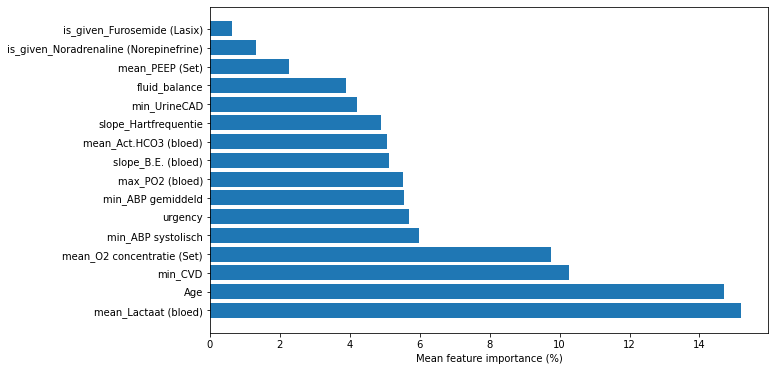

In [154]:
present=False

am_show_features = 60 if len(X_train.columns)>=30 else len(X_train.columns)
fi = CB_AF.feature_importances_
plt.figure(figsize=(10,6))
indices_T0 = np.argsort(fi)[::-1][0:am_show_features]
if present:
    plt.barh(range(am_show_features),fi[indices_T0],color="#e898ac")
else:
    plt.barh(range(am_show_features),fi[indices_T0])
plt.yticks(range(am_show_features), X_train.columns[indices_T0])
plt.xlabel("Mean feature importance (%)")
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
#plt.tight_layout()
plt.show()

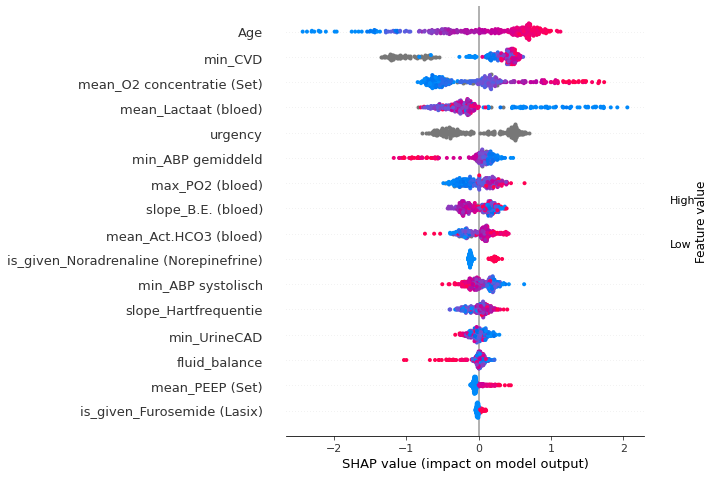

In [155]:
present=False

explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,show=False)


## Combo validation 

In [156]:
validation_type_string = "combo"

### Data Import

In [157]:
if one_half_hour_model:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_1_5_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_1_5_hours.csv") 
elif six_hour_model:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_6_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_6_hours.csv") 
else:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_12_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_12_hours.csv") 
        
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"HospAdmissionID":"patientid","AgeOnAdmission":"Age","ICUSessionID":"admissionid"})
AF_dataset_uzgent.loc[AF_dataset_uzgent.sepsis_extra_opn_measuredat > AF_dataset_uzgent.AF_measuredat,"sepsis_bool_extra_opn"]=0

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


In [158]:
AF_dataset_uzgent["is_given_NORepinefrine"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_norepinephrine']>0,"is_given_NORepinefrine"]=1

AF_dataset_uzgent["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent["mean_VI_calcium carbonate"]>1)|(AF_dataset_uzgent["mean_VI_calcium chloride"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset_uzgent["is_given_Dopamine (Inotropin)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_dopamine']>0,"is_given_Dopamine (Inotropin)"]=1

AF_dataset_uzgent['is_given_Propofol (Diprivan)']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset_uzgent['is_given_Fentanyl']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_fentanyl']>0,'is_given_Fentanyl']=1

AF_dataset_uzgent["is_given_Furosemide (Lasix)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_DI_furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset_uzgent["is_given_LoopDiuretics"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent['mean_DI_furosemide']>0),"is_given_LoopDiuretics"]=1

AF_dataset_uzgent["sepsis_bool"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent.sepsis_bool_comorb_source==1) | (AF_dataset_uzgent.sepsis_bool_extra_opn==1),"sepsis_bool"]=1

AF_dataset_uzgent.loc[AF_dataset_uzgent.icuurg=="URGENT","icuurg"]=1
AF_dataset_uzgent.loc[AF_dataset_uzgent.icuurg!=1,"icuurg"]=0

In [159]:
AF_dataset["is_given_Magnesiumsulfaat (MgSO4)"]=0
AF_dataset.loc[AF_dataset['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1

AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[AF_dataset['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[ (AF_dataset['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Dopamine (Inotropin)']=0
AF_dataset.loc[AF_dataset['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

In [160]:
#Rename for distr change 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'mean_PEEP_M_ALL':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_URINE_VOL':'mean_UrineCAD', 
                            'max_PEEP_M_ALL':'max_PEEP (Set)','min_PEEP_M_ALL':'min_PEEP (Set)',
                            'max_PHOSPHATE_ALL':'max_Fosfaat (bloed)','min_HR_ALL':'min_Hartfrequentie','mean_HR_ALL':'mean_Hartfrequentie','slope_HR_ALL':'slope_Hartfrequentie',
                            'min_PH_ART_ALL':'min_pH (bloed)','mean_PH_ART_ALL':'mean_pH (bloed)','max_PH_ART_ALL':'max_pH (bloed)',
                            'mean_LACTATE_ART':'mean_Lactaat (bloed)','max_LACTATE_ART':'max_Lactaat (bloed)' ,'min_LACTATE_ART':'min_Lactaat (bloed)' , 
                            'min_URINE_VOL':'min_UrineCAD', 'max_URINE_VOL':'max_UrineCAD', 'slope_URINE_VOL':'slope_UrineCAD', 'icuurg':'urgency',
                            'mean_BALANS-Tot.':'fluid_balance', 'slope_RESPRATE_ALL':'slope_O2 l/min','Length':'Height',
                            'mean_HCO3_ART':'mean_Act.HCO3 (bloed)','max_HCO3_ART':'max_Act.HCO3 (bloed)','min_HCO3_ART':'min_Act.HCO3 (bloed)','slope_HCO3_ART':'slope_Act.HCO3 (bloed)',
                            'mean_PO2_ART':'mean_PO2 (bloed)','min_PO2_ART':'min_PO2 (bloed)','max_PO2_ART':'max_PO2 (bloed)','slope_PO2_ART':'slope_PO2 (bloed)',
                            'mean_BE_ART':'mean_B.E. (bloed)','min_BE_ART':'min_B.E. (bloed)','max_BE_ART':'max_B.E. (bloed)','slope_BE_ART':'slope_B.E. (bloed)',
                            'mean_PCO2_ART':'mean_pCO2 (bloed)','min_PCO2_ART':'min_pCO2 (bloed)','max_PCO2_ART':'max_pCO2 (bloed)','slope_PCO2_ART':'slope_pCO2 (bloed)',
                            'mean_IBP_M':'mean_ABP gemiddeld','min_IBP_M':'min_ABP gemiddeld','max_IBP_M':'max_ABP gemiddeld','slope_IBP_M':'slope_ABP gemiddeld',
                            'mean_IBP_S':'mean_ABP systolisch','min_IBP_S':'min_ABP systolisch','max_IBP_S':'max_ABP systolisch','slope_IBP_S':'slope_ABP systolisch',
                            'mean_FIO2_MV_ALL':'mean_O2 concentratie (Set)','max_FIO2_MV_ALL':'max_O2 concentratie (Set)','min_FIO2_MV_ALL':'min_O2 concentratie (Set)',
                            'mean_O2SAT_ART':'mean_O2-Saturatie (bloed)','max_O2SAT_ART':'max_O2-Saturatie (bloed)','min_O2SAT_ART':'min_O2-Saturatie (bloed)',
                           'min_NS_propofol':'min_Propofol (Diprivan)', 'min_NS_fentanyl':'min_Fentanyl', 'mean_RESPRATE_ALL':'mean_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                           'mean_PHOSPHATE_ALL':'mean_Fosfaat (bloed)', 'kurt_CVD':'kurt_CVD', 'max_HR_ALL':'max_Hartfrequentie', "max_PLATELETS":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_RESPRATE_ALL':'max_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                                        'min_PHOSPHATE_ALL':'min_Fosfaat (bloed)', 'mean_CVD':'mean_CVD', 
                                        "min_PLATELETS":"min_Thrombo's (bloed)","slope_PLATELETS":"slope_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_UREA_ALL':'max_Ureum (bloed)','mean_UREA_ALL':'mean_Ureum (bloed)','min_UREA_ALL':'min_Ureum (bloed)'})

#Rename for standard 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"slope_PO2_ART":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={ 'min_RESPRATE_ALL':'min_O2 l/min', "mean_PLATELETS":"mean_Thrombo's (bloed)",
                                        'min_CVD':'min_CVD'})

In [161]:
AF_temp_db_uzgent = AF_dataset_uzgent[(AF_dataset_uzgent.AF==0)&(AF_dataset_uzgent.AF_orig==0)&(AF_dataset_uzgent.admissionid!=AF_dataset_uzgent.date_corresponds_to_AF_admid)]
AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

AF_NOW_uzgent = pd.concat([AF_temp_db_uzgent,AF_dataset_uzgent[AF_dataset_uzgent.AF==1]]).reset_index(drop=True)
AF_NOW = pd.concat([AF_temp_db,AF_dataset[AF_dataset.AF==1]]).reset_index(drop=True)

In [162]:
from sklearn.model_selection import train_test_split

train_patientid_uzgent,test_patientid_uzgent = train_test_split(AF_NOW_uzgent.patientid.unique(), test_size=0.2, random_state=42)
train_patientid,test_patientid = train_test_split(AF_NOW.patientid.unique(), test_size=0.2, random_state=42)

train_AF_dataset = AF_NOW[AF_NOW.patientid.isin(train_patientid)]
train_AF_dataset_uzgent = AF_NOW_uzgent[AF_NOW_uzgent.patientid.isin(train_patientid_uzgent)]
test_AF_dataset = AF_NOW[AF_NOW.patientid.isin(test_patientid)]
test_AF_dataset_uzgent = AF_NOW_uzgent[AF_NOW_uzgent.patientid.isin(test_patientid_uzgent)]

In [163]:
uzgent_drop_columns = ['patientid', 'hadm_id', 'admittime', 'AF_measuredat', 'intime',
       'outtime', 'admissionid', 'lengthofstay']

drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta","weightsource","dischargedat","heightsource",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid","location","admissionyeargroup"]

uzgent_drop_columns.append('date_corresponds_to_AF_admid')
drop_columns.append('date_corresponds_to_AF_admid')

In [164]:
X_train_or_amst = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))]#[train_AF_dataset.columns.drop(drop_columns)]
X_test_or_amst = test_AF_dataset[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))]#[test_AF_dataset.columns.drop(uzgent_drop_columns)]
y_train_amst = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))].AF
y_test_amst = test_AF_dataset[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))].AF

X_train_or_uzgent = train_AF_dataset_uzgent[(train_AF_dataset_uzgent.AF==1)|((train_AF_dataset_uzgent.AF_orig==0)&(train_AF_dataset_uzgent.AF==0))]
X_test_or_uzgent = test_AF_dataset_uzgent[(test_AF_dataset_uzgent.AF==1)|((test_AF_dataset_uzgent.AF_orig==0)&(test_AF_dataset_uzgent.AF==0))]
y_train_uzgent = train_AF_dataset_uzgent[(train_AF_dataset_uzgent.AF==1)|((train_AF_dataset_uzgent.AF_orig==0)&(train_AF_dataset_uzgent.AF==0))].AF
y_test_uzgent = test_AF_dataset_uzgent[(test_AF_dataset_uzgent.AF==1)|((test_AF_dataset_uzgent.AF_orig==0)&(test_AF_dataset_uzgent.AF==0))].AF

### Testing

In [165]:
if one_half_hour_model:
    feature_columns = ['Age',
        'mean_Lactaat (bloed)',
        'slope_Hartfrequentie',
        'mean_UrineCAD',
        'mean_O2-Saturatie (bloed)',
        'max_PO2 (bloed)',
        'mean_O2 concentratie (Set)',
        'urgency',
        "min_Thrombo's (bloed)",
        'is_given_Noradrenaline (Norepinefrine)',
        'min_Ureum (bloed)',
        'is_given_Furosemide (Lasix)',
        'min_Act.HCO3 (bloed)',
        'Weight',
        'mean_PEEP (Set)',
        'fluid_balance',
        'mean_CVD',
        'slope_ABP systolisch',
        'min_pH (bloed)',
        'slope_ABP gemiddeld',
        ]

elif six_hour_model:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'is_given_Noradrenaline (Norepinefrine)',
        'mean_Lactaat (bloed)',
        'min_UrineCAD',
        'mean_O2 concentratie (Set)',
        'max_PO2 (bloed)',
        'min_CVD',
        'is_given_Furosemide (Lasix)',
        'fluid_balance',
        'min_ABP gemiddeld',
        'mean_PEEP (Set)',
        'mean_Act.HCO3 (bloed)',
        'min_ABP systolisch',
        'urgency',
        'slope_B.E. (bloed)']

else:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'mean_O2 concentratie (Set)',
        'mean_UrineCAD',
        'max_PO2 (bloed)',
        'max_CVD',
        'mean_Lactaat (bloed)',
        'min_pH (bloed)',
        'mean_O2-Saturatie (bloed)',
        'urgency',
        'mean_PEEP (Set)']

            
X_train_amst=X_train_or_amst[feature_columns]    
X_test_amst=X_test_or_amst[feature_columns]   
X_train_uzgent=X_train_or_uzgent[feature_columns]    
X_test_uzgent=X_test_or_uzgent[feature_columns]  

X_train = X_train_amst.append(X_train_uzgent).reset_index(drop=True).sample(len(X_train_amst)+len(X_train_uzgent),random_state=42)
#X_train = X_train_amst
#X_train = X_train_uzgent

y_train = np.append(y_train_amst,y_train_uzgent)[X_train.index.values]
#y_train = y_train_amst
#y_train = y_train_uzgent

In [166]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]

if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=6, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=5, l2_leaf_reg=2, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=4, l2_leaf_reg=2, class_weights=AF_class_balance)

CB_AF.fit(X_train,y_train)

0:	learn: 0.6861822	total: 2.18ms	remaining: 871ms
100:	learn: 0.5298519	total: 238ms	remaining: 704ms
200:	learn: 0.4975046	total: 484ms	remaining: 480ms
300:	learn: 0.4717043	total: 659ms	remaining: 217ms
399:	learn: 0.4455113	total: 860ms	remaining: 0us


In [167]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.81      0.77      0.79      1928
          AF       0.79      0.83      0.81      1998

    accuracy                           0.80      3926
   macro avg       0.80      0.80      0.80      3926
weighted avg       0.80      0.80      0.80      3926



In [168]:
print("BALANCED TEST AMSTERDAM PATIENTS")
print(classification_report(y_test_amst,CB_AF.predict(X_test_amst),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_amst,label=y_test_amst), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_amst,CB_AF.predict(X_test_amst)),4)))
print(50*"=")

BALANCED TEST AMSTERDAM PATIENTS
              precision    recall  f1-score   support

       No-AF       0.72      0.72      0.72       350
          AF       0.69      0.68      0.69       311

    accuracy                           0.70       661
   macro avg       0.70      0.70      0.70       661
weighted avg       0.70      0.70      0.70       661



AUC = 0.7789
MCC = 0.4078


In [169]:
print("BALANCED TEST UZGENT PATIENTS")
print(classification_report(y_test_uzgent,CB_AF.predict(X_test_uzgent),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_uzgent,label=y_test_uzgent), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_uzgent,CB_AF.predict(X_test_uzgent)),4)))
print(50*"=")

BALANCED TEST UZGENT PATIENTS
              precision    recall  f1-score   support

       No-AF       0.80      0.67      0.73       165
          AF       0.69      0.81      0.75       151

    accuracy                           0.74       316
   macro avg       0.75      0.74      0.74       316
weighted avg       0.75      0.74      0.74       316



AUC = 0.8299
MCC = 0.4904


In [170]:
combo_uzgent_y_test = y_test_uzgent
combo_uzgent_predict = CB_AF.predict(X_test_uzgent)
combo_amst_y_test = y_test_amst
combo_amst_predict = CB_AF.predict(X_test_amst)

In [171]:
temp_large_db = AF_dataset_uzgent[((AF_dataset_uzgent.AF==0)&(~AF_dataset_uzgent.patientid.isin(AF_NOW_uzgent.patientid)))|(AF_dataset_uzgent.patientid.isin(test_patientid_uzgent))]

y_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]


print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")


uzgent_result_dataframe = pandas_result_AF_maker("all patients uzgent",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test_uzgent,CB_AF.predict(X_test_uzgent),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_uzgent,label=y_test_uzgent), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_uzgent,CB_AF.predict(X_test_uzgent)),4)))
print(50*"=")


uzgent_result_dataframe = pandas_result_AF_maker("balanced test uzgent",X_test_uzgent,y_test_uzgent,CB_AF,uzgent_result_dataframe)

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       1.00      0.73      0.84     12070
          AF       0.04      0.81      0.07       151

    accuracy                           0.73     12221
   macro avg       0.52      0.77      0.46     12221
weighted avg       0.98      0.73      0.83     12221



AUC = 0.8468
MCC = 0.1343
ECE normalized AUC (%) = 5.76 %
ESCE normalized AUC (%) = -4.57 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.80      0.67      0.73       165
          AF       0.69      0.81      0.75       151

    accuracy                           0.74       316
   macro avg       0.75      0.74      0.74       316
weighted avg       0.75      0.74      0.74       316



AUC = 0.8299
MCC = 0.4904
ECE normalized AUC (%) = 9.24 %
ESCE normalized AUC (%) = 4.78 %


<Figure size 432x288 with 0 Axes>

In [172]:
temp_large_db = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.patientid.isin(AF_NOW.patientid)))|(AF_dataset.patientid.isin(test_patientid))]

y_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]

print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("all patients amsterdam",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test_amst,CB_AF.predict(X_test_amst),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_amst,label=y_test_amst), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_amst,CB_AF.predict(X_test_amst)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("balanced test amsterdam",X_test_amst,y_test_amst,CB_AF,uzgent_result_dataframe)

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.65      0.78     13320
          AF       0.04      0.68      0.08       311

    accuracy                           0.65     13631
   macro avg       0.52      0.67      0.43     13631
weighted avg       0.97      0.65      0.77     13631



AUC = 0.7395
MCC = 0.104
ECE normalized AUC (%) = 5.59 %
ESCE normalized AUC (%) = -4.1 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.72      0.72      0.72       350
          AF       0.69      0.68      0.69       311

    accuracy                           0.70       661
   macro avg       0.70      0.70      0.70       661
weighted avg       0.70      0.70      0.70       661



AUC = 0.7789
MCC = 0.4078
ECE normalized AUC (%) = 7.18 %
ESCE normalized AUC (%) = 2.67 %


<Figure size 432x288 with 0 Axes>

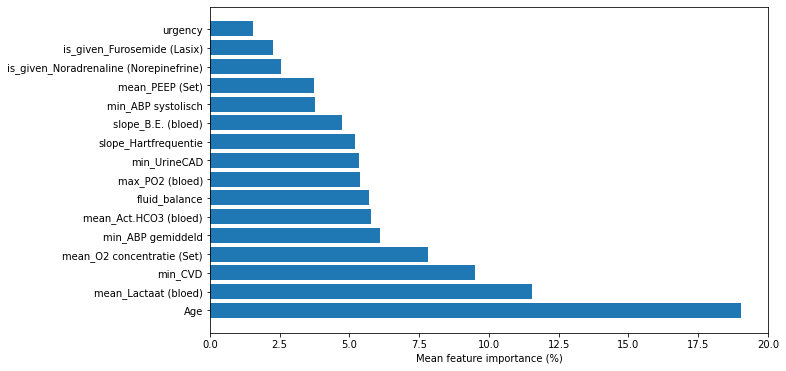

In [173]:
present=False

am_show_features = 60 if len(X_train.columns)>=30 else len(X_train.columns)
fi = CB_AF.feature_importances_
plt.figure(figsize=(10,6))
indices_T0 = np.argsort(fi)[::-1][0:am_show_features]
if present:
    plt.barh(range(am_show_features),fi[indices_T0],color="#e898ac")
else:
    plt.barh(range(am_show_features),fi[indices_T0])
plt.yticks(range(am_show_features), X_train.columns[indices_T0])
plt.xlabel("Mean feature importance (%)")
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
#plt.tight_layout()
plt.show()

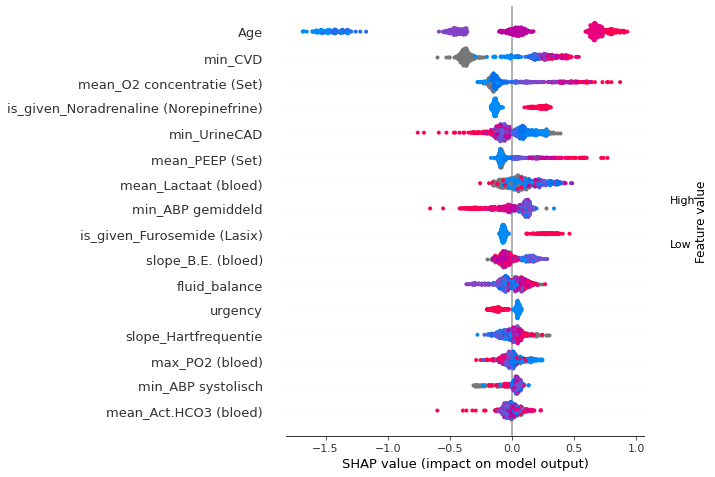

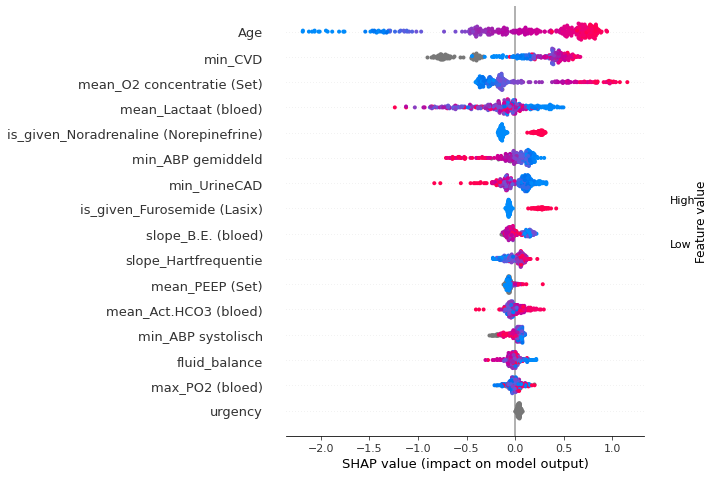

In [174]:
present=False

plt.figure()
explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test_amst)
shap.summary_plot(shap_values, X_test_amst,show=False)
plt.plot()
plt.figure()
explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test_uzgent)
shap.summary_plot(shap_values, X_test_uzgent,show=False)

## Direct validation

In [175]:
validation_type_string = "direct"

### Data Import

In [176]:
if one_half_hour_model:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_1_5_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_1_5_hours.csv") 
elif six_hour_model:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_6_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_6_hours.csv") 
else:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_12_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_12_hours.csv") 

AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"HospAdmissionID":"patientid","AgeOnAdmission":"Age","ICUSessionID":"admissionid"})
AF_dataset_uzgent.loc[AF_dataset_uzgent.sepsis_extra_opn_measuredat > AF_dataset_uzgent.AF_measuredat,"sepsis_bool_extra_opn"]=0

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


In [177]:
AF_dataset_uzgent["is_given_NORepinefrine"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_norepinephrine']>0,"is_given_NORepinefrine"]=1

AF_dataset_uzgent["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent["mean_VI_calcium carbonate"]>1)|(AF_dataset_uzgent["mean_VI_calcium chloride"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset_uzgent["is_given_Dopamine (Inotropin)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_dopamine']>0,"is_given_Dopamine (Inotropin)"]=1

AF_dataset_uzgent['is_given_Propofol (Diprivan)']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset_uzgent['is_given_Fentanyl']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_fentanyl']>0,'is_given_Fentanyl']=1

AF_dataset_uzgent["is_given_Furosemide (Lasix)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_DI_furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset_uzgent["is_given_LoopDiuretics"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent['mean_DI_furosemide']>0),"is_given_LoopDiuretics"]=1

AF_dataset_uzgent["sepsis_bool"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent.sepsis_bool_comorb_source==1) | (AF_dataset_uzgent.sepsis_bool_extra_opn==1),"sepsis_bool"]=1

AF_dataset_uzgent.loc[AF_dataset_uzgent.icuurg=="URGENT","icuurg"]=1
AF_dataset_uzgent.loc[AF_dataset_uzgent.icuurg!=1,"icuurg"]=0

In [178]:
AF_dataset["is_given_Magnesiumsulfaat (MgSO4)"]=0
AF_dataset.loc[AF_dataset['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1

AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[AF_dataset['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[ (AF_dataset['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Dopamine (Inotropin)']=0
AF_dataset.loc[AF_dataset['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

In [179]:
#Rename for distr change 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'mean_PEEP_M_ALL':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_URINE_VOL':'mean_UrineCAD', 
                            'max_PEEP_M_ALL':'max_PEEP (Set)','min_PEEP_M_ALL':'min_PEEP (Set)',
                            'max_PHOSPHATE_ALL':'max_Fosfaat (bloed)','min_HR_ALL':'min_Hartfrequentie','mean_HR_ALL':'mean_Hartfrequentie','slope_HR_ALL':'slope_Hartfrequentie',
                            'min_PH_ART_ALL':'min_pH (bloed)','mean_PH_ART_ALL':'mean_pH (bloed)','max_PH_ART_ALL':'max_pH (bloed)',
                            'mean_LACTATE_ART':'mean_Lactaat (bloed)','max_LACTATE_ART':'max_Lactaat (bloed)' ,'min_LACTATE_ART':'min_Lactaat (bloed)' , 
                            'min_URINE_VOL':'min_UrineCAD', 'max_URINE_VOL':'max_UrineCAD', 'slope_URINE_VOL':'slope_UrineCAD', 'icuurg':'urgency',
                            'mean_BALANS-Tot.':'fluid_balance', 'slope_RESPRATE_ALL':'slope_O2 l/min','Length':'Height',
                            'mean_HCO3_ART':'mean_Act.HCO3 (bloed)','max_HCO3_ART':'max_Act.HCO3 (bloed)','min_HCO3_ART':'min_Act.HCO3 (bloed)','slope_HCO3_ART':'slope_Act.HCO3 (bloed)',
                            'mean_PO2_ART':'mean_PO2 (bloed)','min_PO2_ART':'min_PO2 (bloed)','max_PO2_ART':'max_PO2 (bloed)','slope_PO2_ART':'slope_PO2 (bloed)',
                            'mean_BE_ART':'mean_B.E. (bloed)','min_BE_ART':'min_B.E. (bloed)','max_BE_ART':'max_B.E. (bloed)','slope_BE_ART':'slope_B.E. (bloed)',
                            'mean_PCO2_ART':'mean_pCO2 (bloed)','min_PCO2_ART':'min_pCO2 (bloed)','max_PCO2_ART':'max_pCO2 (bloed)','slope_PCO2_ART':'slope_pCO2 (bloed)',
                            'mean_IBP_M':'mean_ABP gemiddeld','min_IBP_M':'min_ABP gemiddeld','max_IBP_M':'max_ABP gemiddeld','slope_IBP_M':'slope_ABP gemiddeld',
                            'mean_IBP_S':'mean_ABP systolisch','min_IBP_S':'min_ABP systolisch','max_IBP_S':'max_ABP systolisch','slope_IBP_S':'slope_ABP systolisch',
                            'mean_FIO2_MV_ALL':'mean_O2 concentratie (Set)','max_FIO2_MV_ALL':'max_O2 concentratie (Set)','min_FIO2_MV_ALL':'min_O2 concentratie (Set)',
                            'mean_O2SAT_ART':'mean_O2-Saturatie (bloed)','max_O2SAT_ART':'max_O2-Saturatie (bloed)','min_O2SAT_ART':'min_O2-Saturatie (bloed)',
                           'min_NS_propofol':'min_Propofol (Diprivan)', 'min_NS_fentanyl':'min_Fentanyl', 'mean_RESPRATE_ALL':'mean_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                           'mean_PHOSPHATE_ALL':'mean_Fosfaat (bloed)', 'kurt_CVD':'kurt_CVD', 'max_HR_ALL':'max_Hartfrequentie', "max_PLATELETS":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_RESPRATE_ALL':'max_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                                        'min_PHOSPHATE_ALL':'min_Fosfaat (bloed)', 'mean_CVD':'mean_CVD', 
                                        "min_PLATELETS":"min_Thrombo's (bloed)","slope_PLATELETS":"slope_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_UREA_ALL':'max_Ureum (bloed)','mean_UREA_ALL':'mean_Ureum (bloed)','min_UREA_ALL':'min_Ureum (bloed)'})

#Rename for standard 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"slope_PO2_ART":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={ 'min_RESPRATE_ALL':'min_O2 l/min', "mean_PLATELETS":"mean_Thrombo's (bloed)",
                                        'min_CVD':'min_CVD'})

In [180]:
AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]
AF_temp_db_uzgent = AF_dataset_uzgent[(AF_dataset_uzgent.AF==0)&(AF_dataset_uzgent.admissionid!=AF_dataset_uzgent.date_corresponds_to_AF_admid)]

AF_NOW_uzgent = AF_temp_db_uzgent.append(AF_dataset_uzgent[AF_dataset_uzgent.AF==1]).reset_index(drop=True)

AF_NOW = AF_temp_db.append(AF_dataset[(AF_dataset.AF==1)&(AF_dataset.admissionid.isin(AF_temp_db.date_corresponds_to_AF_admid))]).reset_index(drop=True)
AF_NOW = AF_NOW[(AF_NOW.AF==1)|(AF_NOW.date_corresponds_to_AF_admid.isin(AF_NOW.admissionid))]
AF_NOW = AF_NOW[~AF_NOW.admissionid.isin(AF_NOW[(AF_NOW.AF==0)&(AF_NOW.admissionid.isin(AF_NOW.date_corresponds_to_AF_admid))].admissionid.values)]


In [181]:
from sklearn.model_selection import train_test_split

train_patientid_uzgent,test_patientid_uzgent = train_test_split(AF_NOW_uzgent.date_corresponds_to_AF_admid.unique(), test_size=0.2, random_state=42)
train_patientid,test_patientid = train_test_split(AF_NOW.date_corresponds_to_AF_admid.unique(), test_size=0.2, random_state=42)

train_AF_dataset = AF_NOW[AF_NOW.date_corresponds_to_AF_admid.isin(train_patientid)]
test_AF_dataset = AF_NOW_uzgent[AF_NOW_uzgent.date_corresponds_to_AF_admid.isin(test_patientid_uzgent)]
test_AF_dataset_amst = AF_NOW[AF_NOW.date_corresponds_to_AF_admid.isin(test_patientid)]

In [182]:
uzgent_drop_columns = ['patientid', 'hadm_id', 'admittime', 'AF_measuredat', 'intime',
       'outtime', 'admissionid', 'lengthofstay']

drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta","weightsource","dischargedat","heightsource",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid","location","admissionyeargroup"]

uzgent_drop_columns.append('date_corresponds_to_AF_admid')
drop_columns.append('date_corresponds_to_AF_admid')

In [183]:
X_train_or = train_AF_dataset#[train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset#[test_AF_dataset.columns.drop(mimic_drop_columns)]
y_train = train_AF_dataset.AF
y_test = test_AF_dataset.AF

In [184]:
X_train_or = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))]#[train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))]#[test_AF_dataset.columns.drop(mimic_drop_columns)]
y_train = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))].AF
y_test = test_AF_dataset[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))].AF

X_test_or_amst = test_AF_dataset_amst[(test_AF_dataset_amst.AF==1)|((test_AF_dataset_amst.AF_orig==0)&(test_AF_dataset_amst.AF==0))]#[test_AF_dataset.columns.drop(mimic_drop_columns)]
y_test_amst = test_AF_dataset_amst[(test_AF_dataset_amst.AF==1)|((test_AF_dataset_amst.AF_orig==0)&(test_AF_dataset_amst.AF==0))].AF

### Testing

In [185]:
if one_half_hour_model:
    feature_columns = ['Age',
        'mean_Lactaat (bloed)',
        'slope_Hartfrequentie',
        'mean_UrineCAD',
        'mean_O2-Saturatie (bloed)',
        'max_PO2 (bloed)',
        'mean_O2 concentratie (Set)',
        'urgency',
        "min_Thrombo's (bloed)",
        'is_given_Noradrenaline (Norepinefrine)',
        'min_Ureum (bloed)',
        'is_given_Furosemide (Lasix)',
        'min_Act.HCO3 (bloed)',
        'Weight',
        'mean_PEEP (Set)',
        'fluid_balance',
        'mean_CVD',
        'slope_ABP systolisch',
        'min_pH (bloed)',
        'slope_ABP gemiddeld',
        ]

elif six_hour_model:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'is_given_Noradrenaline (Norepinefrine)',
        'mean_Lactaat (bloed)',
        'min_UrineCAD',
        'mean_O2 concentratie (Set)',
        'max_PO2 (bloed)',
        'min_CVD',
        'is_given_Furosemide (Lasix)',
        'fluid_balance',
        'min_ABP gemiddeld',
        'mean_PEEP (Set)',
        'mean_Act.HCO3 (bloed)',
        'min_ABP systolisch',
        'urgency',
        'slope_B.E. (bloed)']

else:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'mean_O2 concentratie (Set)',
        'mean_UrineCAD',
        'max_PO2 (bloed)',
        'max_CVD',
        'mean_Lactaat (bloed)',
        'min_pH (bloed)',
        'mean_O2-Saturatie (bloed)',
        'urgency',
        'mean_PEEP (Set)']

X_train=X_train_or[feature_columns]    
X_test=X_test_or[feature_columns]   

X_test_amst = X_test_or_amst[feature_columns]

In [186]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=6, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=5, l2_leaf_reg=2, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=4, l2_leaf_reg=2, class_weights=AF_class_balance)


CB_AF.fit(X_train,y_train)

0:	learn: 0.6863686	total: 1.42ms	remaining: 568ms
100:	learn: 0.5269912	total: 155ms	remaining: 457ms
200:	learn: 0.4875449	total: 305ms	remaining: 302ms
300:	learn: 0.4513431	total: 442ms	remaining: 145ms
399:	learn: 0.4190783	total: 576ms	remaining: 0us


In [187]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.84      0.80      0.82      1198
          AF       0.81      0.85      0.83      1198

    accuracy                           0.82      2396
   macro avg       0.82      0.82      0.82      2396
weighted avg       0.82      0.82      0.82      2396



In [188]:
print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.70      0.63      0.66       158
          AF       0.66      0.73      0.69       158

    accuracy                           0.68       316
   macro avg       0.68      0.68      0.68       316
weighted avg       0.68      0.68      0.68       316



AUC = 0.756
MCC = 0.3563


In [189]:
direct_y_test = y_test
direct_predict = CB_AF.predict(X_test)
AMST_y_test = y_test_amst
AMST_predict = CB_AF.predict(X_test_amst)

In [190]:
# plt.hist(CB_AF.predict(X_test)[np.where(y_test==0)],density=True)

In [191]:
temp_large_db = AF_dataset_uzgent[((AF_dataset_uzgent.AF==0)&(~AF_dataset_uzgent.patientid.isin(AF_NOW_uzgent.patientid)))|(AF_dataset_uzgent.patientid.isin(test_AF_dataset.patientid))]

y_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]


print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("all patients",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("balanced test",X_test,y_test,CB_AF,uzgent_result_dataframe)

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.64      0.78     12053
          AF       0.03      0.73      0.05       161

    accuracy                           0.64     12214
   macro avg       0.51      0.68      0.41     12214
weighted avg       0.98      0.64      0.77     12214



AUC = 0.7626
MCC = 0.0871
ECE normalized AUC (%) = 7.94 %
ESCE normalized AUC (%) = -6.8 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.70      0.63      0.66       158
          AF       0.66      0.73      0.69       158

    accuracy                           0.68       316
   macro avg       0.68      0.68      0.68       316
weighted avg       0.68      0.68      0.68       316



AUC = 0.756
MCC = 0.3563
ECE normalized AUC (%) = 8.13 %
ESCE normalized AUC (%) = 3.33 %


<Figure size 432x288 with 0 Axes>

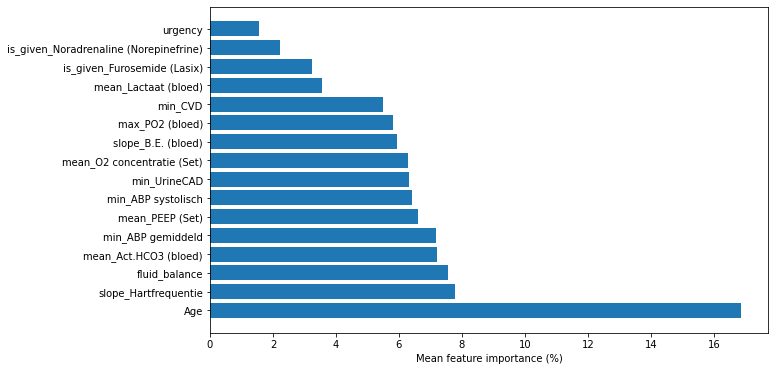

In [192]:
present=False

am_show_features = 60 if len(X_train.columns)>=30 else len(X_train.columns)
fi = CB_AF.feature_importances_
plt.figure(figsize=(10,6))
indices_T0 = np.argsort(fi)[::-1][0:am_show_features]
if present:
    plt.barh(range(am_show_features),fi[indices_T0],color="#e898ac")
else:
    plt.barh(range(am_show_features),fi[indices_T0])
plt.yticks(range(am_show_features), X_train.columns[indices_T0])
plt.xlabel("Mean feature importance (%)")
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
#plt.tight_layout()
plt.show()

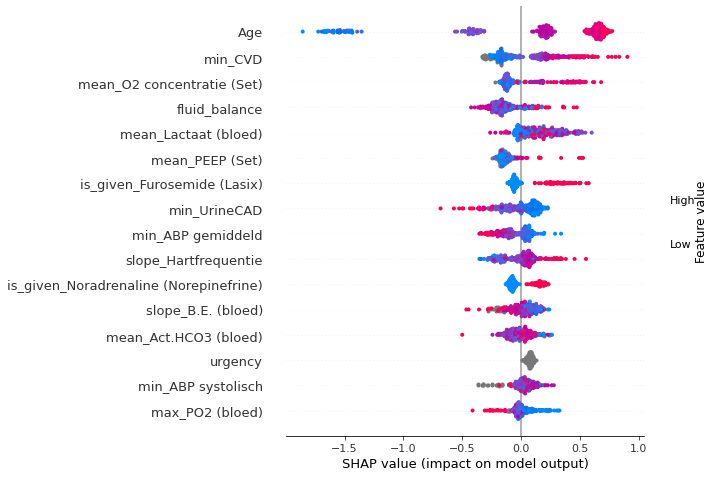

In [193]:
present=False

explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,show=False)


# P-tests

In [194]:
#bonferri correction: alpha/m, with m the amount of total tests
from scipy.stats import ranksums

# print("p-value comparisons")
# print(100*"=")
# print("")
    

# print("Direct - Internal")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict[np.where(direct_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict[np.where(direct_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","all",ranksums(direct_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","AF",ranksums(direct_predict[np.where(direct_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","NO AF",ranksums(direct_predict[np.where(direct_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Combo uzgent - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Internal","all",ranksums(combo_uzgent_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Internal","AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Internal","NO AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Combo amst - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict[np.where(combo_amst_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict[np.where(combo_amst_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","all",ranksums(combo_amst_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","AF",ranksums(combo_amst_predict[np.where(combo_amst_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","NO AF",ranksums(combo_amst_predict[np.where(combo_amst_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Transfer - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","all",ranksums(transfer_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Transfer - Combo uzgent ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,combo_uzgent_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],combo_uzgent_predict[np.where(combo_uzgent_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],combo_uzgent_predict[np.where(combo_uzgent_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo uzgent","all",ranksums(transfer_predict,combo_uzgent_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo uzgent","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],combo_uzgent_predict[np.where(combo_uzgent_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo uzgent","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],combo_uzgent_predict[np.where(combo_uzgent_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Transfer - Direct ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,direct_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","all",ranksums(transfer_predict,direct_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Combo uzgent - Direct ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict,direct_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]))
# print(40*"=")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Direct","all",ranksums(combo_uzgent_predict,direct_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Direct","AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Direct","NO AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])



In [195]:
uzgent_result_dataframe

,model,validation_type,patient_group,NO AF patients,AF patients,NO AF recall,AF recall,NO AF precision,AF precision,NO AF f1,AF f1,mcc,auc,ECE,ESCE
0,1.5,transfer,balanced test,183,184,0.759563,0.809783,0.798851,0.772021,0.778711,0.790451,0.570108,0.859705,0.089453,0.039840
0,1.5,transfer,all patients,18934,184,0.747438,0.809783,0.997533,0.030217,0.854564,0.058260,0.124350,0.854152,0.065771,-0.061127
0,1.5,combo,all patients uzgent,18934,184,0.733126,0.815217,0.997557,0.028830,0.845140,0.055690,0.120286,0.851310,0.058826,-0.051587
0,1.5,combo,balanced test uzgent,183,184,0.732240,0.815217,0.797619,0.753769,0.763533,0.783290,0.549419,0.853469,0.092907,0.052085
0,1.5,combo,all patients amsterdam,13191,344,0.699795,0.723837,0.989813,0.059159,0.819914,0.109378,0.144036,0.794687,0.020665,-0.009612
0,1.5,combo,balanced test amsterdam,378,344,0.735450,0.723837,0.745308,0.713467,0.740346,0.718615,0.459031,0.809039,0.070584,0.031264
0,1.5,direct,all patients,18970,194,0.514760,0.907216,0.998160,0.018761,0.679233,0.036762,0.084501,0.816245,0.177544,-0.177440
0,1.5,direct,balanced test,183,183,0.519126,0.901639,0.840708,0.652174,0.641892,0.756881,0.455398,0.827496,0.095191,0.033892
0,12,transfer,balanced test,165,150,0.703030,0.833333,0.822695,0.718391,0.758170,0.771605,0.538720,0.847273,0.087534,0.040794
0,12,transfer,all patients,9675,150,0.724961,0.833333,0.996448,0.044867,0.839296,0.085150,0.151876,0.850600,0.065123,-0.058105


In [196]:
uzgent_p_value_result_dataframe

,model,comparison,AF_group,p_value
0,1.5,Direct - Internal,all,0.000053
0,1.5,Direct - Internal,AF,0.014964
0,1.5,Direct - Internal,NO AF,0.001036
0,1.5,Combo uzgent - Internal,all,0.922861
0,1.5,Combo uzgent - Internal,AF,0.413636
...,...,...,...,...
0,6,Transfer - Direct,AF,0.264224
0,6,Transfer - Direct,NO AF,0.234932
0,6,Combo uzgent - Direct,all,0.836378
0,6,Combo uzgent - Direct,AF,0.187597


In [198]:
# uzgent_p_value_result_dataframe.to_csv("../results/uzgent_p_value_result_dataframe.csv",index=False)

In [199]:
# uzgent_result_dataframe.to_csv("../results/uzgent_result_dataframe.csv",index=False)

# Patient Demographics GUH

In [ ]:
#227428 SOFA mimic
#226743 	APACHE II 	

#13081 numeric items amst (apache II)

In [ ]:
admissions_pd_uzgent = pd.read_csv(r"Data/uzgent/uzgent-iv-1.0/df_adm_icu.csv",sep=',')
admissions_pd_uzgent = admissions_pd_uzgent.rename(columns={"subject_id":"patientid","stay_id":"admissionid","los":"lengthofstay"})
admissions_pd_uzgent.loc[:,"intime"] = pd.to_datetime(admissions_pd_uzgent.intime)
admissions_pd_uzgent.loc[:,"outtime"] = pd.to_datetime(admissions_pd_uzgent.outtime)
admissions_pd_uzgent.loc[:,"lengthofstay"]=admissions_pd_uzgent.lengthofstay*24
admissions_pd_uzgent.loc[admissions_pd_uzgent.AF_measuredat=="0","AF_measuredat"]=0.0
admissions_pd_uzgent.loc[admissions_pd_uzgent.AF_measuredat!=0,"AF_measuredat"]=(pd.to_datetime(admissions_pd_uzgent[admissions_pd_uzgent.AF_measuredat!=0].AF_measuredat)-pd.to_datetime(admissions_pd_uzgent[admissions_pd_uzgent.AF_measuredat!=0].intime)).dt.total_seconds()/60/60
admissions_pd_uzgent["AF_measuredat"] = np.float32(admissions_pd_uzgent["AF_measuredat"])
admissions_pd_uzgent = admissions_pd_uzgent[admissions_pd_uzgent.lengthofstay>=12]

weight_csv = pd.read_csv("Data/uzgent/uzgent-iv-1.0/icu/csv/chartevents/"+str(226512)+".csv")[["stay_id","valuenum"]]
weight_csv = weight_csv.rename(columns={"subject_id":"patientid","stay_id":"admissionid","valuenum":"weight"})
height_csv = pd.read_csv("Data/uzgent/uzgent-iv-1.0/icu/csv/chartevents/"+str(226730)+".csv")[["stay_id","valuenum"]]
height_csv = height_csv.rename(columns={"subject_id":"patientid","stay_id":"admissionid","valuenum":"height"})


admissions_pd_uzgent = admissions_pd_uzgent.merge(height_csv,how='left',on='admissionid')
admissions_pd_uzgent.loc[(admissions_pd_uzgent.height<50)|(admissions_pd_uzgent.height>250)]=int(admissions_pd_uzgent[(admissions_pd_uzgent.height<50)|(admissions_pd_uzgent.height>250)].height.mean())
admissions_pd_uzgent = admissions_pd_uzgent.merge(weight_csv,how='left',on='admissionid')
admissions_pd_uzgent.loc[(admissions_pd_uzgent.weight<20)|(admissions_pd_uzgent.weight>500)]=int(admissions_pd_uzgent[(admissions_pd_uzgent.weight<20)|(admissions_pd_uzgent.weight>500)].weight.mean())
admissions_pd_uzgent["BMI"]=admissions_pd_uzgent.weight/((admissions_pd_uzgent.height/100)**2)
    
df_patients = pd.read_csv(r"Data/uzgent/uzgent-iv-1.0/core/csv/patients.csv",sep=',')
df_patients = df_patients.rename(columns={"subject_id":"patientid","anchor_age":"Age"})

admissions_pd_uzgent = admissions_pd_uzgent.merge(df_patients[['patientid','Age','gender']],how='left',on='patientid')
#If no gender was specified, the value is -1.
gender_category = {'M':1,"F":0,"":-1}

#Replace the strings with numbers
admissions_pd_uzgent["gender"]=admissions_pd_uzgent["gender"].replace(gender_category)

admissions_pd_uzgent = admissions_pd_uzgent[(admissions_pd_uzgent.AF==0)|((admissions_pd_uzgent.AF==1)&(admissions_pd_uzgent.AF_measuredat>=12))]

print(len(admissions_pd_uzgent.patientid.unique()))

In [ ]:
sofa_uzgent_csv = pd.read_csv("Data/uzgent/uzgent-iv-1.0/uzgent_sofa.csv")[["stay_id","sofa_24hours","starttime","endtime"]]
sofa_uzgent_csv = sofa_uzgent_csv.rename(columns={"stay_id":"admissionid","sofa_24hours":"sofa"})
sofa_uzgent_csv.loc[:,"starttime"]=pd.to_datetime(sofa_uzgent_csv.starttime)
sofa_uzgent_csv.loc[:,"endtime"]=pd.to_datetime(sofa_uzgent_csv.endtime)
sofa_uzgent_csv = sofa_uzgent_csv.merge(admissions_pd_uzgent[["admissionid","patientid","intime","outtime","AF_measuredat","AF"]],how="inner",on="admissionid")
sofa_uzgent_csv["time_to_adm"] = (pd.to_datetime(sofa_uzgent_csv.starttime)-pd.to_datetime(sofa_uzgent_csv.intime)).dt.total_seconds()/60/60
sofa_mean_day_uzgent = sofa_uzgent_csv[sofa_uzgent_csv.time_to_adm<=24][["patientid","admissionid","sofa"]].groupby(["patientid","admissionid"]).mean().reset_index()
sofa_mean_day_uzgent = sofa_mean_day_uzgent.rename(columns={"sofa":"sofa_first24h"})
sofa_AF_uzgent = sofa_uzgent_csv[(sofa_uzgent_csv.AF==1)&(sofa_uzgent_csv.AF_measuredat - sofa_uzgent_csv.time_to_adm <= 1)&(sofa_uzgent_csv.AF_measuredat - sofa_uzgent_csv.time_to_adm >= 0)][["patientid","admissionid","sofa"]].groupby(["patientid","admissionid"]).mean().reset_index()
sofa_AF_uzgent = sofa_AF_uzgent.rename(columns={"sofa":"sofa_AF_matched"})
admissions_pd_uzgent = admissions_pd_uzgent.merge(sofa_mean_day_uzgent,how='left',on=['patientid','admissionid'])
admissions_pd_uzgent = admissions_pd_uzgent.merge(sofa_AF_uzgent,how='left',on=['patientid','admissionid'])

In [ ]:
admissions_pd_amst = pd.read_csv("Data/Extracted/admissions_demographics.csv")
admissions_pd_amst = admissions_pd_amst[admissions_pd_amst.lengthofstay>=12]
admissions_pd_amst.loc[admissions_pd_amst.Weight==0] = admissions_pd_amst[admissions_pd_amst.Weight>0].Weight.mean()
admissions_pd_amst.loc[admissions_pd_amst.Height==0] = admissions_pd_amst[admissions_pd_amst.Height>0].Height.mean()
admissions_pd_amst["BMI"]=admissions_pd_amst.Weight/((admissions_pd_amst.Height/100)**2)
admissions_pd_amst["AF_measuredat"] = admissions_pd_amst["AF_measuredat"]/1000/60/60
admissions_pd_amst = admissions_pd_amst[(admissions_pd_amst.AF==0)|((admissions_pd_amst.AF==1)&(admissions_pd_amst.AF_measuredat>=12))]

print(len(admissions_pd_amst.patientid.unique()))

amst_sofa = pd.read_csv(r"Data/sofa.csv",sep=',')
amst_apache_II = pd.read_csv(r"Data/apache_ii.csv",sep=',')
admissions_pd_amst = admissions_pd_amst.merge(amst_sofa[["admissionid","sofa_total_score"]],how='left',on='admissionid')
admissions_pd_amst = admissions_pd_amst.merge(amst_apache_II[["admissionid","apache_ii_total_score"]],how='left',on='admissionid')

In [ ]:
print(len(admissions_pd_uzgent.patientid.unique()))
print(len(admissions_pd_amst.patientid.unique()))
print(len(admissions_pd_uzgent[admissions_pd_uzgent.AF==1].patientid.unique()))
print(len(admissions_pd_amst[admissions_pd_amst.AF==1].patientid.unique()))
print(len(admissions_pd_uzgent[admissions_pd_uzgent.AF==0].patientid.unique()))
print(len(admissions_pd_amst[admissions_pd_amst.AF==0].patientid.unique()))

In [ ]:
print("AMSTERDAM COLUMNS")
print("")
print(admissions_pd_amst.columns)
print(50*"-")
print("")
print("UZGENT COLUMNS")
print("")
print(admissions_pd_uzgent.columns)

In [ ]:
admissions_pd_uzgent[admissions_pd_uzgent.AF==1].admission_type.value_counts()

In [ ]:
(1292+623)/len(admissions_pd_uzgent[admissions_pd_uzgent.AF==1])*100

In [ ]:
admissions_pd_amst[admissions_pd_amst.AF==0].specialty.value_counts()

In [ ]:
(6172+2092+1019+32)/len(admissions_pd_amst[admissions_pd_amst.AF==0])*100

In [ ]:
admissions_pd_uzgent.admission_type.value_counts()

In [ ]:
admissions_pd_uzgent[admissions_pd_uzgent.AF>=0].drop_duplicates("patientid").ethnicity.value_counts()

In [ ]:
print(admissions_pd_amst[admissions_pd_amst.AF==0].cardio_surgery_new.sum())
print(admissions_pd_amst[admissions_pd_amst.AF==0].sepsis_bool.sum())
admissions_pd_amst[admissions_pd_amst.AF==0].drop_duplicates("patientid").describe()

In [ ]:
print(admissions_pd_uzgent[admissions_pd_uzgent.AF==0].cardiac_bool_new.sum())
print(admissions_pd_uzgent[admissions_pd_uzgent.AF==0].sepsis_bool.sum())
admissions_pd_uzgent[admissions_pd_uzgent.AF==0].drop_duplicates("patientid").describe()

In [ ]:
5165*0.692352

In [ ]:
admissions_pd_uzgent.AF_measuredat

In [ ]:
1-0.519807

In [ ]:
1868*0.480193

In [ ]:
from scipy import stats

stats.ttest_ind(admissions_pd_amst[admissions_pd_amst.AF==0].sofa_total_score, admissions_pd_uzgent[(admissions_pd_uzgent.AF==0)&(~admissions_pd_uzgent.sofa_first24h.isna())].sofa_first24h)

In [ ]:
stats.ranksums(admissions_pd_amst[admissions_pd_amst.AF==0].Gender_category, admissions_pd_uzgent[admissions_pd_uzgent.AF==0].gender)

# All results visualisation

In [ ]:
guh_df = pd.read_csv("uzgent_af_prediction_results.csv")
guh_df["dataset"]="uzgent"
guh_df.loc[guh_df.patient_group.str.contains("uzgent"),'patient_group']=guh_df.patient_group.str.replace(' uzgent', '')
mimic_df = pd.read_csv("mimic_af_prediction_results.csv")
mimic_df["dataset"]="mimic"
mimic_df.loc[mimic_df.patient_group.str.contains("mimic"),'patient_group']=mimic_df.patient_group.str.replace(' mimic', '')
amc_df = pd.read_csv("amsterdam_af_prediction_results.csv")
amc_df["dataset"]="amst"

results_df = pd.concat([guh_df,mimic_df,amc_df])

In [ ]:
results_df

In [ ]:
patient_group_string = "all patients"

for val_string in ["combo","direct","transfer"]:
    validation_comparison_string = val_string#"direct" #"combo" "direct" "transfer"

    plot_df = results_df[(results_df.validation_type.str.contains(validation_comparison_string+"|base model",regex=True))&(results_df.patient_group.str.contains(patient_group_string))]
    min_ylim = np.min(plot_df.auc.values)-0.025
    i = 0
    len_patient_groups = len(plot_df.patient_group.unique())
    
    if validation_comparison_string=="combo":
        fig, ax = plt.subplots(4,3,figsize=(15,15))
    else:
        fig, ax = plt.subplots(2,3,figsize=(15,7))
        
    for patient_group in plot_df.patient_group.unique():
        for model_string in plot_df.model.unique():
                temp_plot_df = plot_df[(plot_df.model==model_string)&((plot_df.validation_type=="base model")|(plot_df.patient_group == patient_group))]
                ax[int((i-i%3)/3),i%3].grid(alpha=0.5,axis='y')
                ax[int((i-i%3)/3),i%3].bar(temp_plot_df.dataset.values,temp_plot_df.auc.values)
                ax[int((i-i%3)/3),i%3].set_title(model_string+ " "+patient_group)
                if i%3 == 0:
                    ax[int((i-i%3)/3),i%3].set_ylabel("AUC")
                ax[int((i-i%3)/3),i%3].set_ylim([min_ylim,1.025])


                i += 1
    if validation_comparison_string == "combo":
        fig.suptitle("Combo: Trained on both amsterdam + external dataset, evaluated on both",fontsize=20)
    elif validation_comparison_string == "direct":
        fig.suptitle("Direct: Trained on amsterdam, evaluated on external dataset",fontsize=20)
    elif validation_comparison_string == "transfer":
        fig.suptitle("Transfer: Trained on external dataset, evaluated on external dataset",fontsize=20)
    plt.savefig("results/"+validation_comparison_string+"_"+patient_group_string+"_results.jpg", bbox_inches="tight")
    plt.savefig("results/"+validation_comparison_string+"_"+patient_group_string+"_results.png", bbox_inches="tight")